# Wikimedia Research - Translation Imbalances: Testing hypothesis #2

In this notebook we aim to find answer to research questions by interacting with the data sources relevant to it, __the related statement is__:
> The strongest communities also correspond to the larger languages, and these communities tend to be under the “self-focus” bias, which prompts tend to create and translate content in their first language first (and about their own culture first). 

__Research questions:__
- Do users prefer to translate content in their native language(s)? If so, what influences this behavior?

__Data sources__
- Data obtained from the APIs by language edition: https://www.mediawiki.org/wiki/API:Main_page

__Steps:__
1. Tests
2. Data extraction/collection
3. Data processing
4. Data analysis


# 1. Tests

#### Initial test with dumps

In [1]:
# import libraries here
import gzip  # necessary for decompressing dump file into text format
import pandas as pd
import numpy as np

__NOTE__: The MediaWiki API can be language specific. We can use it to contruct the relevant datasets of the users we need. The following will yield different results:
- https://es.wikipedia.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount
- https://de.wikipedia.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount
- https://www.mediawiki.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount&format=json

In [2]:
import requests

url = "https://www.mediawiki.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount&format=json"

# Making a GET request
response = requests.get(url)
# See status code
print(response.status_code)
# See request text
print(response.text)

response.json()


200
{"batchcomplete":"","query":{"users":[{"userid":398607,"name":"Adamw","editcount":1507}]}}


{'batchcomplete': '',
 'query': {'users': [{'userid': 398607, 'name': 'Adamw', 'editcount': 1507}]}}

In [3]:
import requests

url = "https://en.wikipedia.org/w/rest.php/v1/search/page?q=earth&limit=1"

# Making a GET request
response = requests.get(url)
# See URL
response.url
# See status code
response.status_code
# See request header
response.text


'{"pages":[{"id":9228,"key":"Earth","title":"Earth","excerpt":"<span class=\\"searchmatch\\">Earth</span> is the third planet from the Sun and the only place known in the universe where life has originated and found habitability. <span class=\\"searchmatch\\">Earth</span> is the only planet","matched_title":null,"description":"Third planet from the Sun","thumbnail":{"mimetype":"image/jpeg","width":60,"height":60,"duration":null,"url":"//upload.wikimedia.org/wikipedia/commons/thumb/c/cb/The_Blue_Marble_%28remastered%29.jpg/60px-The_Blue_Marble_%28remastered%29.jpg"}}]}'

# 2. Implementation

## Data collection

In [50]:
# import general libraries
import csv
import ast
import re
import requests
import pandas as pd

In [51]:
# we are adding this list because the CSV files includes items that are not in it
allowed_languages = ['aa', 'ab', 'ace', 'ady', 'af', 'ak', 'als', 'alt', 'am', 'ami', 'an', 'ang', 'ar', 'arc', 'ary',
                     'arz', 'as', 'ast', 'atj', 'av', 'avk', 'awa', 'ay', 'az', 'azb', 'ba', 'ban', 'bar', 'bat-smg',
                     'bcl', 'be', 'be-tarask', 'bg', 'bh', 'bi', 'bjn', 'blk', 'bm', 'bn', 'bo', 'bpy', 'br', 'bs',
                     'bug', 'bxr', 'ca', 'cbk-zam', 'cdo', 'ce', 'ceb', 'ch', 'cho', 'chr', 'chy', 'ckb', 'co', 'cr',
                     'crh', 'cs', 'csb', 'cu', 'cv', 'cy', 'da', 'dag', 'de', 'din', 'diq', 'dsb', 'dty', 'dv', 'dz',
                     'ee', 'el', 'eml', 'en', 'eo', 'es', 'et', 'eu', 'ext', 'fa', 'ff', 'fi', 'fiu-vro', 'fj', 'fo', 
                     'gur', 'fr', 'frp', 'frr', 'fur', 'fy', 'ga', 'gag', 'gan', 'gcr', 'gd', 'gl', 'glk', 'gn', 'gom',
                     'gor', 'got', 'gu', 'guw', 'gv', 'ha', 'hak', 'haw', 'he', 'hi', 'hif', 'ho', 'hr', 'hsb', 'ht', 
                     'hu', 'hy', 'hyw', 'hz', 'ia', 'id', 'ie', 'ig', 'ii', 'ik', 'ilo', 'inh', 'io', 'is', 'it', 'iu',
                     'ja', 'jam', 'jbo', 'jv', 'ka', 'kaa', 'kab', 'kbd', 'kbp', 'kcg', 'kg', 'ki', 'kj', 'kk', 'kl', 
                     'km', 'kn', 'ko', 'koi', 'kr', 'krc', 'ks', 'ksh', 'ku', 'kv', 'kw', 'ky', 'la', 'lad', 'lb', 'lbe', 
                     'lez', 'lfn', 'lg', 'li', 'lij', 'lld', 'lmo', 'ln', 'lo', 'lrc', 'lt', 'ltg', 'lv', 'mad', 'mai', 
                     'map-bms', 'mdf', 'mg', 'mh', 'mhr', 'mi', 'min', 'mk', 'ml', 'mn', 'mni', 'mnw', 'mr', 'mrj', 'ms',
                     'mt', 'mus', 'mwl', 'my', 'myv', 'mzn', 'na', 'nah', 'nap', 'nds', 'nds-nl', 'ne', 'new', 'ng', 'nia',
                     'nl', 'nn', 'no', 'nov', 'nqo', 'nrm', 'nso', 'nv', 'ny', 'oc', 'olo', 'om', 'or', 'os', 'pa', 'pag',
                     'pam', 'pap', 'pcd', 'pcm', 'pdc', 'pfl', 'pi', 'pih', 'pl', 'pms', 'pnb', 'pnt', 'ps', 'pt', 'pwn',
                     'qu', 'rm', 'rmy', 'rn', 'ro', 'roa-rup', 'roa-tara', 'ru', 'rue', 'rw', 'sa', 'sah', 'sat', 'sc',
                     'scn', 'sco', 'sd', 'se', 'sg', 'sh', 'shi', 'shn', 'si', 'simple', 'sk', 'skr', 'sl', 'smn', 'sm', 
                     'sn', 'so', 'sq', 'sr', 'srn', 'ss', 'st', 'stq', 'su', 'sv', 'sw', 'szl', 'szy', 'ta', 'tay', 'tcy',
                     'te', 'tet', 'tg', 'th', 'ti', 'tk', 'tl', 'tn', 'to', 'tpi', 'tr', 'trv', 'ts', 'tt', 'tum', 'tw', 'ty',
                     'tyv', 'udm', 'ug', 'uk', 'ur', 'uz', 've', 'vec', 'vep', 'vi', 'vls', 'vo', 'wa', 'war', 'guc', 'wo', 'wuu',
                     'xal', 'xh', 'xmf', 'yi', 'yo', 'za', 'zea', 'zh', 'zh-classical', 'zh-min-nan', 'zh-yue', 'zu']

In [71]:
## Collect users and languages
from csv import DictReader

# open file in read mode and convert to list of dictionaries
with open('data/users_data_merge.csv', encoding="utf8") as f:
    users = csv.DictReader(f)
    user_dictionary = {}
    
    # make headers lowercase
    users.fieldnames = [h.lower() for h in users.fieldnames]
    
    # iterate over results to initialize copy and set new columns
    for i, row in enumerate(users):
        # initialize fields
        row['edit_counts'] = []
        row['level_lang'] = []
        username = row['username'].split(':')[1]
        row['username'] = username
        
        # update mapper
        user_dictionary[username] =row
    
    
# out
display(users.fieldnames)
display(user_dictionary)    

['username', 'language']

{'Olivier LPB': {'username': 'Olivier LPB',
  'language': "['fr-5', 'en-2']",
  'edit_counts': [],
  'level_lang': []},
 'Gamesmasterg9': {'username': 'Gamesmasterg9',
  'language': "['en-5', 'hi-4', 'bn-3', 'mr-1']",
  'edit_counts': [],
  'level_lang': []},
 'Dvermeirre': {'username': 'Dvermeirre',
  'language': "['fr-5', 'en-5', 'de-1']",
  'edit_counts': [],
  'level_lang': []},
 'Jklamo': {'username': 'Jklamo',
  'language': "['en-3', 'cs-5', 'sk-5', 'fr-1']",
  'edit_counts': [],
  'level_lang': []},
 'Calliopejen1': {'username': 'Calliopejen1',
  'language': "['en-5', 'es-3', 'fr-1']",
  'edit_counts': [],
  'level_lang': []},
 'Jpbrenna': {'username': 'Jpbrenna',
  'language': "['en-5', 'el-2', 'la-2', 'es-2', 'ar-1']",
  'edit_counts': [],
  'level_lang': []},
 'WarKosign': {'username': 'WarKosign',
  'language': "['en-3', 'he-4', 'ru-5']",
  'edit_counts': [],
  'level_lang': []},
 'Appaches': {'username': 'Appaches',
  'language': "['fr-5', 'en-3']",
  'edit_counts': [],
  '

## Data processing

Some possibilities is to have a dataframe that has 
[username],[language],[level],[edit count] 

In [72]:
## Clean initial data and update rows and prepare data for requests
from utils import clean_data_and_update_rows

# we update the 'user_dictionary' rows with extracted data from the 'languages' attribute
# and map languages to users via language_match_dic
user_dictionary, language_match_dict = clean_data_and_update_rows(user_dictionary, allowed_languages)



{'Olivier LPB': {'username': 'Olivier LPB',
  'edit_counts': {'fr': 0, 'en': 0},
  'level_lang': [('fr', '5'), ('en', '2')]},
 'Gamesmasterg9': {'username': 'Gamesmasterg9',
  'edit_counts': {'en': 0, 'hi': 0, 'bn': 0, 'mr': 0},
  'level_lang': [('en', '5'), ('hi', '4'), ('bn', '3'), ('mr', '1')]},
 'Dvermeirre': {'username': 'Dvermeirre',
  'edit_counts': {'fr': 0, 'en': 0, 'de': 0},
  'level_lang': [('fr', '5'), ('en', '5'), ('de', '1')]},
 'Jklamo': {'username': 'Jklamo',
  'edit_counts': {'en': 0, 'cs': 0, 'sk': 0, 'fr': 0},
  'level_lang': [('en', '3'), ('cs', '5'), ('sk', '5'), ('fr', '1')]},
 'Calliopejen1': {'username': 'Calliopejen1',
  'edit_counts': {'en': 0, 'es': 0, 'fr': 0},
  'level_lang': [('en', '5'), ('es', '3'), ('fr', '1')]},
 'Jpbrenna': {'username': 'Jpbrenna',
  'edit_counts': {'en': 0, 'el': 0, 'la': 0, 'es': 0, 'ar': 0},
  'level_lang': [('en', '5'),
   ('el', '2'),
   ('la', '2'),
   ('es', '2'),
   ('ar', '1')]},
 'WarKosign': {'username': 'WarKosign',
  'edi

In [54]:
## Per each language, make request to get the data and merge it with larger dictionary
# Reference: https://www.mediawiki.org/w/api.php?action=help&modules=query%2Busers
import traceback
from time import sleep

from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# general
user_edit_counts = defaultdict(list)
langs = list(language_match_dict.keys())

# set requests parameters to retry on 'Max retries exceeded with url' and have enough wait time between exceptions
session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('https://', adapter)

# used to track call number
api_call_number = 0

# initialize
slice_start = 0
slice_end = 50
users_len = 0

while (len(langs) > 0) or (slice_end < users_len):
    try:
        # check to update slice values
        if slice_end >= users_len:
            print("checking...")
            lang = langs.pop() if langs else lang

            slice_start = 0
            slice_end = 50
            users_len = len(language_match_dict[lang])
        else:
            slice_start = slice_start + 50
            slice_end =  slice_end + 50 
            
        print('\n\n\n')
        print(f"LANG {lang}\nUSERS' LIST SIZE {users_len}")
        # work with uses batches that make request per 50 users within a user language group
        users_l = language_match_dict[lang][slice_start:slice_end]
        users =  "|".join(users_l)
        url = f'https://{lang}.wikipedia.org/w/api.php?action=query&list=users&ususers={users}&usprop=editcount&format=json'
        lang_call = lang    

        # GET request
        response = session.get(url)
        if response.status_code != 200:
            raise Exception(f"The call failed: {response.status_code}")

        else:
            # See request JSON
            res = response.json()['query']['users']
            print(res)

            # save results to dictionary to process later

            # AW: Although I like the encapsulation of each user's fetched
            # information under data/users/, it's more efficient to swap
            # containment levels and instead save a csv for all users' edit
            # counts on a language wiki, at the end of this function.  This
            # is a much smaller number of files, and matches the structure of
            # iteration in program logic which becomes helpful if eg. the
            # application crashes and must be restarted.
            print(f"lang_call\n\n {lang_call}")
            user_edit_counts[lang_call].extend(res)
           

            api_call_number += 1
            print(f'\n\nLIMIT: {len(users_l)} \n\nCALL NUMBER: {api_call_number}')
            
    
    except requests.exceptions.ConnectionError as errc:
        print ("Error Connecting:",errc)
    
    except Exception as e:
        print(e)
        traceback.print_exc()
      


checking...




LANG tcy
USERS' LIST SIZE 1
[{'userid': 37, 'name': 'BHARATHESHA ALASANDEMAJALU', 'editcount': 3887}]
lang_call

 tcy


LIMIT: 1 

CALL NUMBER: 1
checking...




LANG ary
USERS' LIST SIZE 1
[{'name': 'AccountableJune', 'missing': ''}]
lang_call

 ary


LIMIT: 1 

CALL NUMBER: 2
checking...




LANG ckb
USERS' LIST SIZE 1
[{'userid': 5048, 'name': 'Kushared', 'editcount': 15278}]
lang_call

 ckb


LIMIT: 1 

CALL NUMBER: 3
checking...




LANG ksh
USERS' LIST SIZE 1
[{'userid': 15127, 'name': 'KL052', 'editcount': 4}]
lang_call

 ksh


LIMIT: 1 

CALL NUMBER: 4
checking...




LANG tl
USERS' LIST SIZE 1
[{'userid': 120024, 'name': 'Gerald Waldo Luis', 'editcount': 0}]
lang_call

 tl


LIMIT: 1 

CALL NUMBER: 5
checking...




LANG nds
USERS' LIST SIZE 1
[{'userid': 38909, 'name': 'Achampnator', 'editcount': 0}]
lang_call

 nds


LIMIT: 1 

CALL NUMBER: 6
checking...




LANG af
USERS' LIST SIZE 2
[{'userid': 110919, 'name': 'NatriumGedrogt', 'editcount': 0}, {'userid': 5

[{'userid': 481, 'name': 'Mhare', 'editcount': 13726}, {'userid': 125493, 'name': 'Chule87', 'editcount': 23}]
lang_call

 bs


LIMIT: 2 

CALL NUMBER: 40
checking...




LANG tr
USERS' LIST SIZE 10
[{'userid': 19770, 'name': 'Onur', 'editcount': 5234}, {'userid': 772422, 'name': 'Demoxica', 'editcount': 90}, {'userid': 1028851, 'name': 'Kutay', 'editcount': 9816}, {'userid': 826511, 'name': '07', 'editcount': 20057}, {'userid': 1168870, 'name': 'Yollug tigin', 'editcount': 6}, {'userid': 1435792, 'name': 'Bullworth788', 'editcount': 9}, {'userid': 301889, 'name': 'Sonsamsunlu', 'editcount': 80}, {'userid': 1041892, 'name': 'Ahmadkurdi44', 'editcount': 20}, {'userid': 1294382, 'name': 'SirSamvi', 'editcount': 0}, {'userid': 1268537, 'name': 'HaythamKenwai', 'editcount': 35183}]
lang_call

 tr


LIMIT: 10 

CALL NUMBER: 41
checking...




LANG ur
USERS' LIST SIZE 3
[{'userid': 83559, 'name': 'Asimtanveer', 'editcount': 0}, {'userid': 62649, 'name': 'Hammad', 'editcount': 92678}, {'useri

[{'userid': 1584385, 'name': '丘明利', 'editcount': 1602}, {'userid': 2256336, 'name': 'IBayern', 'editcount': 402}, {'userid': 1984896, 'name': 'Relic5064', 'editcount': 381}, {'userid': 2543365, 'name': 'Franklyzzm', 'editcount': 500}, {'userid': 2509231, 'name': 'Unnamelessness', 'editcount': 9}, {'userid': 3064666, 'name': 'Justiyaya', 'editcount': 41}, {'userid': 2797294, 'name': 'Gjdhowls', 'editcount': 1}, {'userid': 3152386, 'name': 'PenangLion', 'editcount': 2}, {'userid': 2192256, 'name': 'Richard923888', 'editcount': 20095}, {'userid': 2190266, 'name': 'Efrainlarrea', 'editcount': 0}, {'userid': 184224, 'name': 'Eastmain', 'editcount': 24}, {'userid': 1376838, 'name': 'Yeeno', 'editcount': 51}, {'userid': 1667628, 'name': '損齋', 'editcount': 466}, {'userid': 2545292, 'name': 'LiamTorres1017', 'editcount': 0}, {'userid': 2452809, 'name': 'Firezzasd', 'editcount': 35}, {'userid': 2896486, 'name': 'SaladH', 'editcount': 0}, {'userid': 1026300, 'name': 'Wu Shan', 'editcount': 225}, 

[{'userid': 15264, 'name': 'Jkadavoor', 'editcount': 5732}, {'userid': 22471, 'name': 'Ranjithsiji', 'editcount': 18806}, {'userid': 101485, 'name': 'Gnoeee', 'editcount': 5192}, {'userid': 45771, 'name': 'Jose Mathew C', 'editcount': 933}, {'userid': 213, 'name': 'Sreejithk2000', 'editcount': 10353}, {'userid': 86212, 'name': 'Firos ak', 'editcount': 212}, {'userid': 55462, 'name': 'MaqsoodPoovadka', 'editcount': 8}, {'userid': 9387, 'name': 'Vicharam', 'editcount': 11611}, {'userid': 108239, 'name': 'Ajeeshkumar4u', 'editcount': 16208}]
lang_call

 ml


LIMIT: 9 

CALL NUMBER: 71
checking...




LANG ja
USERS' LIST SIZE 18
[{'userid': 1004065, 'name': '永続繁栄', 'editcount': 663}, {'userid': 1881, 'name': 'Miya', 'editcount': 33046}, {'userid': 1036472, 'name': 'ツバル', 'editcount': 1917}, {'userid': 293269, 'name': 'Yasunorihayashi', 'editcount': 89}, {'userid': 1554881, 'name': 'YTRK', 'editcount': 8241}, {'userid': 16765, 'name': 'JuthaDDA', 'editcount': 16261}, {'userid': 1852471, 'na

[{'userid': 74102, 'name': 'Powermelon', 'editcount': 26585}]
lang_call

 lt


LIMIT: 1 

CALL NUMBER: 79
checking...




LANG es
USERS' LIST SIZE 80
[{'userid': 3369536, 'name': 'AlejandroGallego', 'editcount': 6}, {'userid': 105495, 'name': 'ProtoplasmaKid', 'editcount': 24465}, {'userid': 3879292, 'name': 'CoroneldelNorte', 'editcount': 566}, {'userid': 63211, 'name': 'Banfield', 'editcount': 61033}, {'userid': 3241117, 'name': 'TASAIRES', 'editcount': 233}, {'userid': 929364, 'name': 'AMPERIO', 'editcount': 858}, {'userid': 1622051, 'name': 'Diego Moya', 'editcount': 1407}, {'userid': 1964446, 'name': 'Guillermo2149', 'editcount': 103}, {'userid': 4143336, 'name': 'Fujiiy', 'editcount': 73}, {'userid': 1054478, 'name': 'Gerardo Noriega', 'editcount': 1664}, {'userid': 1768333, 'name': 'Fluffernutter', 'editcount': 1}, {'userid': 4428210, 'name': 'Azael Hernández', 'editcount': 141}, {'userid': 4207933, 'name': 'Ce Ele 415', 'editcount': 1489}, {'userid': 3488347, 'name': 'TheRichic

[{'userid': 20992459, 'name': 'D. Benjamin Miller', 'editcount': 3486}, {'userid': 22150936, 'name': 'United Union', 'editcount': 7239}, {'userid': 11916782, 'name': 'Mz7', 'editcount': 74902}, {'userid': 4110769, 'name': 'Rystheguy', 'editcount': 8409}, {'userid': 28100673, 'name': 'Info2Learn', 'editcount': 850}, {'userid': 28391108, 'name': 'OriginalOldMan', 'editcount': 36}, {'userid': 631250, 'name': 'Ww2censor', 'editcount': 106233}, {'userid': 287452, 'name': 'Sasuke Sarutobi', 'editcount': 5909}, {'userid': 31520, 'name': 'Sekicho', 'editcount': 9712}, {'userid': 5863685, 'name': 'Uksharma3', 'editcount': 6175}, {'userid': 3815666, 'name': 'Lillingen', 'editcount': 1402}, {'userid': 22777203, 'name': 'Tylusine', 'editcount': 6256}, {'userid': 16123725, 'name': 'Darylgolden', 'editcount': 17493}, {'userid': 31980208, 'name': 'Heliosxeros', 'editcount': 7509}, {'userid': 18620083, 'name': 'Thureinminnoo', 'editcount': 11}, {'userid': 30551354, 'name': 'Mr.Liam.Darcy', 'editcount'

[{'userid': 1793210, 'name': 'Misha Wolf', 'editcount': 1943}, {'userid': 45770873, 'name': 'Candleblox', 'editcount': 66}, {'userid': 44718850, 'name': 'PaulGamerBoy360', 'editcount': 543}, {'userid': 38528968, 'name': '63616e', 'editcount': 22}, {'userid': 38448542, 'name': 'Losipov', 'editcount': 39325}, {'userid': 45854474, 'name': 'Mellamelina', 'editcount': 5171}, {'userid': 43990583, 'name': 'OttawaPoliticsGuy', 'editcount': 607}, {'userid': 19955841, 'name': 'Hakimi97', 'editcount': 93}, {'userid': 36076999, 'name': 'Arcoria', 'editcount': 112}, {'userid': 36761478, 'name': 'Kline', 'editcount': 12945}, {'userid': 111277, 'name': 'Runner1928', 'editcount': 4788}, {'userid': 126457, 'name': 'Andrew Gray', 'editcount': 54953}, {'userid': 138883, 'name': 'Danaman5', 'editcount': 9735}, {'userid': 19661960, 'name': 'Gtaf', 'editcount': 274}, {'userid': 258000, 'name': 'King of Hearts', 'editcount': 68210}, {'userid': 25936582, 'name': 'Petillés', 'editcount': 410}, {'userid': 81903

[{'userid': 1506351, 'name': 'Olivier LPB', 'editcount': 19419}, {'userid': 54275, 'name': 'Dvermeirre', 'editcount': 170}, {'userid': 2137385, 'name': 'Appaches', 'editcount': 1412}, {'userid': 1402311, 'name': 'Antimuonium', 'editcount': 58923}, {'userid': 492320, 'name': 'Pensées de Pascal', 'editcount': 17969}, {'userid': 871043, 'name': 'Gael13011', 'editcount': 31280}, {'userid': 1381337, 'name': 'Kozam', 'editcount': 31749}, {'userid': 6386, 'name': 'LeFaune', 'editcount': 1384}, {'userid': 2327194, 'name': 'Natalie.Desautels', 'editcount': 598}, {'userid': 151175, 'name': 'Cqui', 'editcount': 10676}, {'userid': 2289993, 'name': 'Phokhamvone', 'editcount': 925}, {'userid': 1134657, 'name': 'Alexgrim', 'editcount': 1500}, {'userid': 13979, 'name': 'Popo le Chien', 'editcount': 25495}, {'userid': 179940, 'name': 'Loiseaulybre', 'editcount': 3121}, {'userid': 1377350, 'name': 'YanikB', 'editcount': 52418}, {'userid': 554374, 'name': 'Nicolas Perrault III', 'editcount': 303}, {'user

__Observations:__ 197 calls on average.

In [ ]:
# TODO:  AW: Very cool!  Also consider pushing this into a regular python module and including dummy data as a test fixture.


# {"batchcomplete":"","query":{"users":[{"userid":398607,"name":"Adamw","editcount":1506}]}}
# NOTE: run it if you can run the previous two lines OR if you want to test dummy data 

# dummy data to use when there is not internet connection
user_edit_counts_temp = {
    'nl': [{"userid":198607,"name":"Ahn-nath","editcount":15}],
    'es': [{"userid":298607,"name":"Adamw","editcount":156}, 
           {"userid":198607,"name":"Ahn-nath","editcount":160},
           {"userid":298607,"name":"Galahad","editcount":4058}
          ], 
           
    'en': [{"userid":298607,"name":"Adamw","editcount":156}, 
           {"userid":198607,"name":"Ahn-nath","editcount":150},
           {"userid":398607,"name":"Galahad","editcount":4056},
           {"userid":498607,"name":"S9H","editcount":4056}
          ],
    'de': [{"userid":298607,"name":"Adamw","editcount":3506},
          {"userid":498607,"name":"S9H","editcount":24056}]
}

user_edit_counts = user_edit_counts_temp

In [20]:
## Process edit counts
for lang, lang_list in user_edit_counts.items(): 
   
    for user_group in lang_list:
        
        if user_group.get('editcount', None):
            # find the user list based on the mapped username
            name = user_group['name']
            user_row = user_dictionary[name]

            # update the edits counts of the language
            user_row['edit_counts'][lang] = user_group.get('editcount', 0)

# out 
user_dictionary

{'Olivier LPB': {'username': 'Olivier LPB',
  'edit_counts': {'fr': 19419, 'en': 323},
  'level_lang': [('fr', '5'), ('en', '2')]},
 'Gamesmasterg9': {'username': 'Gamesmasterg9',
  'edit_counts': {'en': 2753, 'hi': 3, 'bn': 1, 'mr': 0},
  'level_lang': [('en', '5'), ('hi', '4'), ('bn', '3'), ('mr', '1')]},
 'Dvermeirre': {'username': 'Dvermeirre',
  'edit_counts': {'fr': 170, 'en': 550, 'de': 2},
  'level_lang': [('fr', '5'), ('en', '5'), ('de', '1')]},
 'Jklamo': {'username': 'Jklamo',
  'edit_counts': {'en': 12165, 'cs': 12336, 'sk': 37, 'fr': 24},
  'level_lang': [('en', '3'), ('cs', '5'), ('sk', '5'), ('fr', '1')]},
 'Calliopejen1': {'username': 'Calliopejen1',
  'edit_counts': {'en': 132859, 'es': 216, 'fr': 68},
  'level_lang': [('en', '5'), ('es', '3'), ('fr', '1')]},
 'Jpbrenna': {'username': 'Jpbrenna',
  'edit_counts': {'en': 9862, 'el': 50, 'la': 2, 'es': 1, 'ar': 0},
  'level_lang': [('en', '5'),
   ('el', '2'),
   ('la', '2'),
   ('es', '2'),
   ('ar', '1')]},
 'WarKosign

**NOTE:**
    
    - It seems there is a issue of mismatch of languages and their levels. Start new check from here.

In [21]:
## Create dataframe

# create series for each category and extend them with each objectb
user_list = []
edit_counts = []
level_langs = []
 
for i, group_user in user_dictionary.items():
    # extend each list with each user's items
    general_len = len(group_user["level_lang"])
    user_list.extend([group_user['username']] * general_len)
    edit_counts.extend(group_user['edit_counts'].values())
    level_langs.extend(group_user['level_lang'])

    
# out
display(user_list[:10])
display(edit_counts[:10])
display(level_langs[:10])


display(len(user_list))
display(len(edit_counts))
display(len(level_langs))

['Olivier LPB',
 'Olivier LPB',
 'Gamesmasterg9',
 'Gamesmasterg9',
 'Gamesmasterg9',
 'Gamesmasterg9',
 'Dvermeirre',
 'Dvermeirre',
 'Dvermeirre',
 'Jklamo']

[19419, 323, 2753, 3, 1, 0, 170, 550, 2, 12165]

[('fr', '5'),
 ('en', '2'),
 ('en', '5'),
 ('hi', '4'),
 ('bn', '3'),
 ('mr', '1'),
 ('fr', '5'),
 ('en', '5'),
 ('de', '1'),
 ('en', '3')]

3580

3580

3580

In [23]:
## Connect everything
  
# dictionary of lists 
dicti = {'username':user_list, 'edit_count':edit_counts} 
df_users = pd.DataFrame(dicti)

# update columns
df_users[['language', 'level']] = pd.DataFrame(level_langs, index=df_users.index)
df_users['level'] = pd.to_numeric(df_users['level'])
df_users = df_users[['username', 'language', 'level', 'edit_count']]

    
df_users

,username,language,level,edit_count
0,Olivier LPB,fr,5,19419
1,Olivier LPB,en,2,323
2,Gamesmasterg9,en,5,2753
3,Gamesmasterg9,hi,4,3
4,Gamesmasterg9,bn,3,1
...,...,...,...,...
3575,ChandlerMinh,en,4,7805
3576,ChandlerMinh,hi,2,26
3577,ChandlerMinh,ta,1,29
3578,ChandlerMinh,sa,1,39


## Data analysis

### Questions we want to solve:
1. Do users contribute the most to the Wikipedia editions in languages they claim to be native in?
2. Do users contribute the most to the Wikipedia editions in languages they have a "sufficient" proficiency in? (3-4 levels)
3. What other questions can be asked and answered with this data?

In [24]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
# selecting rows based on condition
rslt_df = df_users
rslt_df['edit count percentage'] = (rslt_df.loc[:, 'edit_count'] /  
                                    df_users.groupby('username')['edit_count'].transform('sum') * 100).round(2)

# levels to filter by
rslt_df1 = rslt_df[rslt_df['level'] == 5]
rslt_df2 = rslt_df[rslt_df['level'] == 4]

print(f'\nDisplaying table showing relationship between user language level and the edit count percentage by native level')
display(rslt_df1)

print(f'\nDisplaying table showing relationship between user language level and the edit count percentage by advanced level')
display(rslt_df2)


Displaying table showing relationship between user language level and the edit count percentage by native level


,username,language,level,edit_count,edit count percentage
0,Olivier LPB,fr,5,19419,98.36
2,Gamesmasterg9,en,5,2753,99.85
6,Dvermeirre,fr,5,170,23.55
7,Dvermeirre,en,5,550,76.18
10,Jklamo,cs,5,12336,50.22
...,...,...,...,...,...
3564,Raladic,en,5,1850,93.25
3565,SomeKindOfGnome,en,5,83,100.00
3568,CantCatchThis,en,5,7,100.00
3570,Peter Horn,nl,5,323,0.31



Displaying table showing relationship between user language level and the edit count percentage by advanced level


,username,language,level,edit_count,edit count percentage
3,Gamesmasterg9,hi,4,3,0.11
22,WarKosign,he,4,18,0.36
30,AlejandroGallego,en,4,23,63.89
34,Fredericknoronha,en,4,5300,90.44
42,Keilana,fr,4,39,0.07
...,...,...,...,...,...
3513,Fueyo221,ast,4,10,27.78
3531,LambMilk,en,4,17,100.00
3562,Lifeofconan,en,4,269,73.90
3572,Peter Horn,en,4,102995,98.39


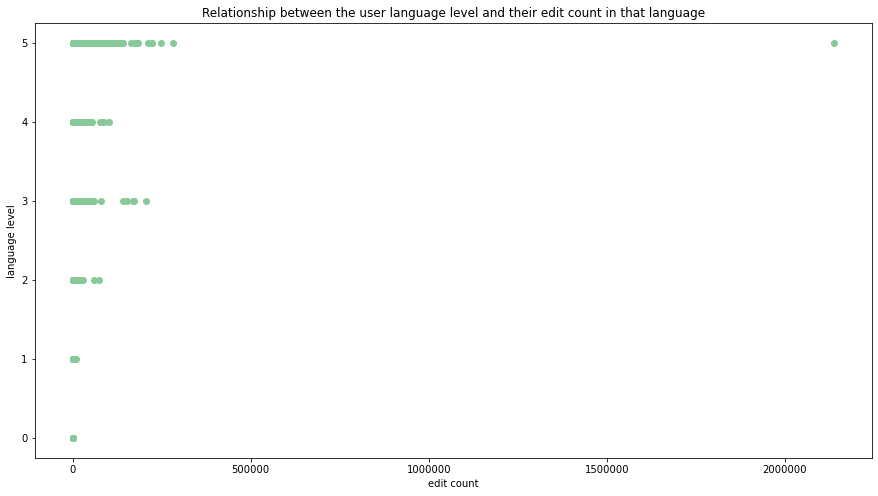

In [28]:
plt.scatter(df_users['edit_count'], df_users['level'], color = '#88c999')
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)

plt.rcParams["figure.figsize"] = (18,8)
plt.title("Relationship between the user language level and their edit count in that language")
plt.xlabel("edit count")
plt.ylabel("language level")
plt.show()

__Observations:__ 

We can superficially see that the closer to the top of the graph the point is, the more prompt to also be closer to the right side of the graph, with the exception of level '4'.

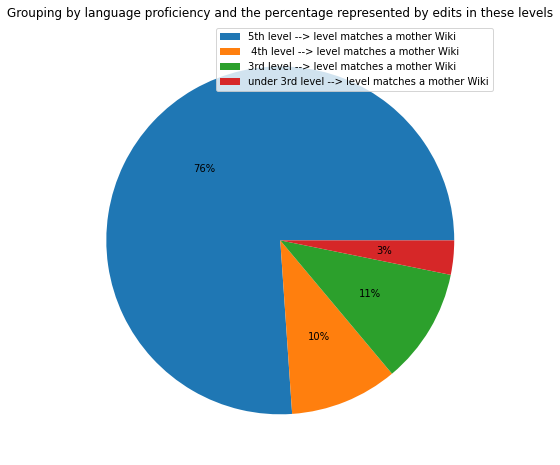

In [29]:
## Display pie

native_high_count_group = df_users.loc[(df_users['level'] == 5) & (df_users['edit count percentage'] > 65.0)]
proficient_high_count_group =  df_users.loc[(df_users['level'] == 4) & (df_users['edit count percentage'] > 65.0)]
sufficient_high_count_group =  df_users.loc[(df_users['level'] == 3) & (df_users['edit count percentage'] > 65.0)]
low_high_count_group =  df_users.loc[(df_users['level'] < 3) & (df_users['edit count percentage'] > 65.0)]

# get counts
counts_list = [native_high_count_group, proficient_high_count_group, sufficient_high_count_group, low_high_count_group]
counts_list_language_edit_number = [len(c) for c in counts_list]

# set labels
summary_labels = ["5th level --> level matches a mother Wiki", 
                  " 4th level --> level matches a mother Wiki", 
                  "3rd level --> level matches a mother Wiki", 
                  "under 3rd level --> level matches a mother Wiki"]

plt.rcParams["figure.figsize"] = (20,8)
plt.title("Grouping by language proficiency and the percentage represented by edits in these levels")
plt.pie(counts_list_language_edit_number, autopct='%.0f%%')
plt.legend( summary_labels, loc='best')
plt.show() 


__Observations:__ 

The pie shows that, on average the total edit count by language tends to correspond to the highest language proficiency. More especifically, the rows of the languages with the biggest count (> 65.5 of the total edit count for one user), tends to correspond to the highest proficiency level. 

In [30]:
from enum import Enum

# we ar defining categories and benchmarks to group users
class EditCategory(Enum):
    BEGINNER = 30
    INTERMEDIATE = 100     
    EXPERT = 200
    

In [31]:
## Create a new category based on absolute numbers of the edit_count column
df_users['category'] = df_users.apply(lambda row: "beginner" if (row.edit_count < EditCategory.BEGINNER.value)
                                      else "intermediate" if (row.edit_count < EditCategory.INTERMEDIATE.value) 
                                      else "expert", axis = 1)

# out
df_users

,username,language,level,edit_count,edit count percentage,category
0,Olivier LPB,fr,5,19419,98.36,expert
1,Olivier LPB,en,2,323,1.64,expert
2,Gamesmasterg9,en,5,2753,99.85,expert
3,Gamesmasterg9,hi,4,3,0.11,beginner
4,Gamesmasterg9,bn,3,1,0.04,beginner
...,...,...,...,...,...,...
3575,ChandlerMinh,en,4,7805,94.95,expert
3576,ChandlerMinh,hi,2,26,0.32,beginner
3577,ChandlerMinh,ta,1,29,0.35,beginner
3578,ChandlerMinh,sa,1,39,0.47,intermediate


Text(0, 0.5, 'edit count')

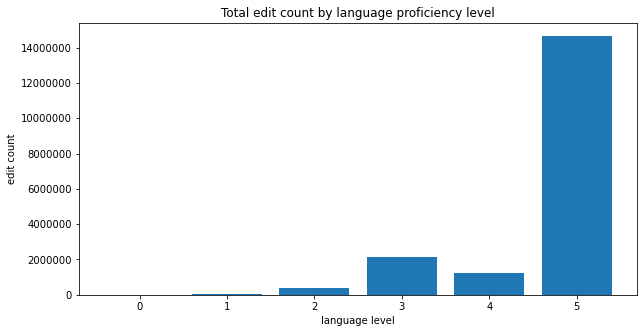

In [32]:
x = df_users.groupby(['level'], as_index=False)['edit_count'].sum()

fig = plt.figure(figsize = (10, 5))
plt.bar(x["level"], x["edit_count"])
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)

plt.rcParams["figure.figsize"] = (20,8)
plt.title("Total edit count by language proficiency level")
plt.xlabel("language level")
plt.ylabel("edit count")

__Observations:__ 

The total edit count by language proficiency shows that, with the exception of level 4, the highest proficiency levels 
    hold the biggest counts. The total count is not a reflection of the overal group, since outliers from a few users may play a role in the difference between level 4 and 3. 

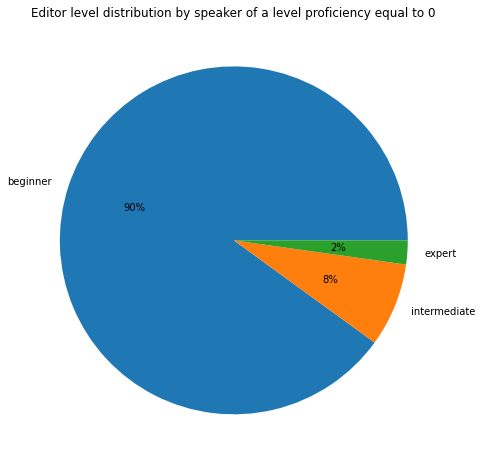

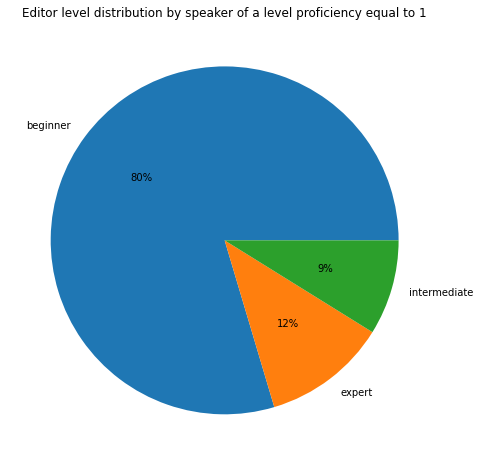

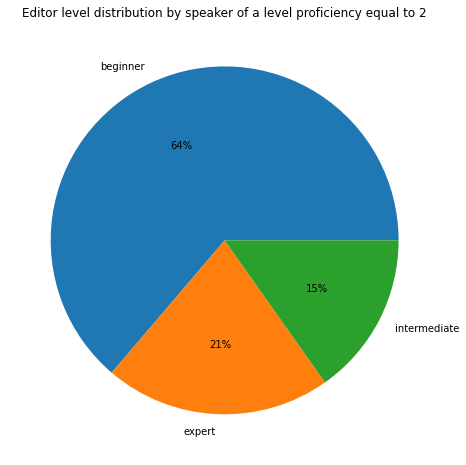

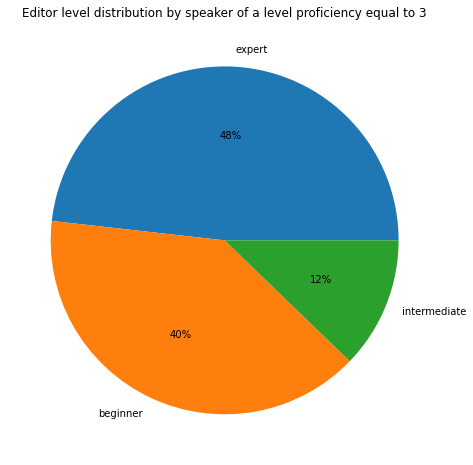

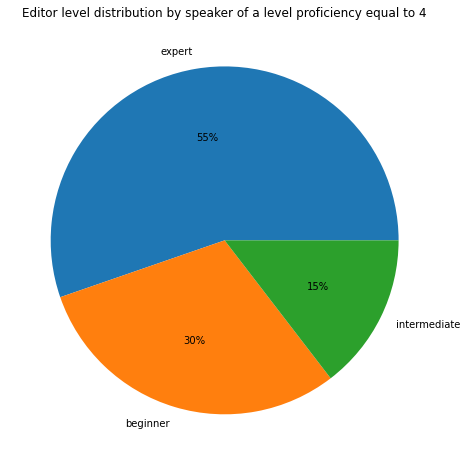

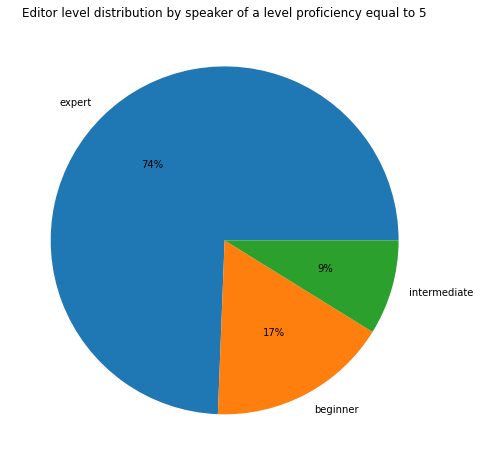

In [33]:
## Show distribution by specific language level
levels = a = sorted(df_users['level'].unique())

for level in levels:
    df = df_users.loc[(df_users['level'] == level)]
    data = df['category']
    values = data.value_counts().values.tolist()
    labels = data.value_counts().index.tolist()
    
    plt.rcParams["figure.figsize"] = (20,8)
    plt.title(f'Editor level distribution by speaker of a level proficiency equal to {level}')
    plt.pie(values, labels=labels, autopct='%.0f%%')
    plt.show()

__Observations__: For this group, we have that
    
- The level "beginner" represents the majority of all users of proficiency level  equal to 0, 1, 2, and 3 (lower proficiency group).
- The level "expert" represents the majority of all users of proficiency level equal to 4 and 5 (advanced, native).

    